In [1]:
from pprint import pformat

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import datasets
import transformers
from transformers import AutoTokenizer

import wandb
from tqdm import tqdm

import lovely_tensors as lt
# lt.monkey_patch()

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

from narrative_time import conversion_utils
from narrative_time import modeling_utils
from narrative_time import event_relations
from narrative_time.modeling import TransformerForRelationPrediction

NUM_RELATIONS = len(event_relations.REL_TO_ID)

%matplotlib inline

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.dpi'] = 150

/home/vlialin/miniconda3/envs/nt/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL_NAME = "google/long-t5-tglobal-large"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

a1_annotations = conversion_utils.get_annotations("../corpus/timebank/nt_format/tbd_a1.jsonl", as_dict=True)
a2_annotations = conversion_utils.get_annotations("../corpus/timebank/nt_format/tbd_a2.jsonl", as_dict=True)

In [3]:
TEST_DOCUMENTS = [
    "PRI19980115.2000.0186",
    "PRI19980213.2000.0313",
    "PRI19980121.2000.2591",
    "ABC19980114.1830.0611",
    "APW19980213.1380",
    "NYT19980402.0453",
]

In [4]:
train_dataset = []
test_dataset = []

n_errors = 0
for annotation_id, annotation in a1_annotations.items():
    annotation = modeling_utils.NTAnnotation.from_json(annotation)
    input_ids, event_left_tokens, event_relation_matrix = modeling_utils.preprocess_document(annotation, tokenizer)

    if annotation_id in TEST_DOCUMENTS:
        test_dataset.append((input_ids, event_left_tokens, event_relation_matrix))
    else:
        train_dataset.append((input_ids, event_left_tokens, event_relation_matrix))

assert len(test_dataset) == len(TEST_DOCUMENTS)

for annotation_id, annotation in a2_annotations.items():
    annotation = modeling_utils.NTAnnotation.from_json(annotation)
    input_ids, event_left_tokens, event_relation_matrix = modeling_utils.preprocess_document(annotation, tokenizer)

    if annotation_id in TEST_DOCUMENTS:
        test_dataset.append((input_ids, event_left_tokens, event_relation_matrix))
    else:
        train_dataset.append((input_ids, event_left_tokens, event_relation_matrix))

assert len(test_dataset) == len(TEST_DOCUMENTS) * 2

In [5]:
ACCUM_STEPS = 1
EARLY_STOPPING = -1

dtype = torch.bfloat16
# bfloat is only supported on 30-series and A-series GPUs (released 2020)
# if you have older ones try float16
# but fp16 usually requires some extra tricks that we didn't implement here
# worst case, you can use float32, but it will be slower and use more memory
model = TransformerForRelationPrediction(MODEL_NAME, num_relations=NUM_RELATIONS).to(device="cuda", dtype=dtype)
model.transformer.gradient_checkpointing_enable()  # needed to fit bigger documents into GPU memory

_n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of model parameters: {_n_params/1e6:.2f}M")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)#, weight_decay=1e-2)

wandb.init(
    project="narrative-time",
    config={
        "model_name": MODEL_NAME,
        "gradient_accumulation_steps": ACCUM_STEPS,
    },
)
wandb.watch(model)

global_step = 0

Some weights of the model checkpoint at google/long-t5-tglobal-large were not used when initializing LongT5Model: ['lm_head.weight']
- This IS expected if you are initializing LongT5Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongT5Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Number of model parameters: 348.60M


wandb: Currently logged in as: guitaricet. Use `wandb login --relogin` to force relogin


In [6]:
metrics = None  # just here for linter to be happy
early_stopping = EARLY_STOPPING
best_f1 = 0
best_epoch = 0

for epoch in tqdm(range(30)):
    shuffled_train_dataset = train_dataset.copy()
    np.random.shuffle(shuffled_train_dataset)

    for input_ids, event_left_tokens, event_relation_matrix in shuffled_train_dataset:
        input_ids = input_ids.to("cuda")
        event_left_tokens = event_left_tokens.to("cuda")
        event_relation_matrix = event_relation_matrix.to("cuda")

        relation_logits = model(input_ids, event_left_tokens)

        num_events = relation_logits.shape[0]
        relation_logits = relation_logits.view(num_events * num_events, NUM_RELATIONS)
        targets = event_relation_matrix.view(num_events * num_events)

        loss = F.cross_entropy(relation_logits, targets, ignore_index=-1)
        loss /= ACCUM_STEPS
        loss.backward()

        if global_step % ACCUM_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()

            accuracy = (relation_logits.argmax(dim=1) == targets).float().mean()
            wandb.log({"loss": loss.item(), "train_accuracy": accuracy.item(), "epoch": epoch}, step=global_step)

        global_step += 1

    # evaluate
    model.eval()

    all_predictions_list = []
    all_targets_list = []

    with torch.no_grad():
        for input_ids, event_left_tokens, event_relation_matrix in test_dataset:
            input_ids = input_ids.to("cuda")
            event_left_tokens = event_left_tokens.to("cuda")
            event_relation_matrix = event_relation_matrix.to("cuda")

            relation_logits = model(input_ids, event_left_tokens)

            num_events = relation_logits.shape[0]
            relation_logits = relation_logits.view(num_events * num_events, NUM_RELATIONS)
            targets = event_relation_matrix.view(num_events * num_events)

            loss = F.cross_entropy(relation_logits, targets, ignore_index=-1)
            accuracy = (relation_logits.argmax(dim=1) == targets).float().mean()

            all_predictions_list.append(relation_logits.argmax(dim=1).cpu())
            all_targets_list.append(targets.cpu())

    all_predictions = torch.cat(all_predictions_list)
    all_targets = torch.cat(all_targets_list)

    # -1 are on the main diagonal (SELF relation) and are ignored
    all_predictions = all_predictions[all_targets != -1]
    all_targets = all_targets[all_targets != -1]

    accuracy = (all_predictions == all_targets).float().mean()
    p = precision_score(all_targets, all_predictions, average="macro", zero_division=0)
    r = recall_score(all_targets, all_predictions, average="macro", zero_division=0)
    f1 = f1_score(all_targets, all_predictions, average="macro", zero_division=0)

    metrics = {
        "test_accuracy": accuracy.item(),
        "test_precision_macro": p,
        "test_recall_macro": r,
        "test_f1_macro": f1,
    }

    wandb.log(metrics, step=global_step)
    model.train()

    # early stopping
    if EARLY_STOPPING > 0:
        if p > best_f1:
            best_f1 = f1
            best_epoch = epoch
            early_stopping = EARLY_STOPPING

            # save model
            checkpoint = {
                "model": model.state_dict(),
                "epoch": epoch,
                "global_step": global_step,
                "metrics": metrics,
            }
            torch.save(checkpoint, "best_model.pt")
            del checkpoint
        else:
            early_stopping -= 1
        
        if early_stopping == 0:
            break

print(f"Best metrics:\n{pformat(metrics)}")
if EARLY_STOPPING > 0:
    # load best model
    checkpoint = torch.load("best_model.pt")
    model.load_state_dict(checkpoint["model"])

wandb.finish()

100%|██████████| 30/30 [09:09<00:00, 18.32s/it]

Best metrics:
{'test_accuracy': 0.4383648633956909,
 'test_f1_macro': 0.2915553492988975,
 'test_precision_macro': 0.32311247616270916,
 'test_recall_macro': 0.28790679859892443}


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
loss,▄█▂▃▁▃▃▃▂▃▁▂▆▁▁▂▅▂▃▃▃▅▄▂▁▃▃▁▁▂▂▃▃▂▂▅▃▃▃▃
test_accuracy,▁█▃▅▆▅▃▃▄▅▄▄▇▆▆▅▅▆▆▅▅▅▅▆▄▅▆▅▇▆
test_f1_macro,▁█▄▆▇▇▅▄▆▇▆▇▆▇▇▆▅▅▆▆▄▅▆▆▆▆▅▆▇▆
test_precision_macro,▁█▅▅▅▆▆▄▇▅▅▆▆▆▆▄▅▅▅▅▄▅▆▆▅▅▄▆▆▆
test_recall_macro,▁█▃▆▆▆▅▄▅▇▆▆▆▆▇▅▅▅▆▆▄▅▆▆▆▅▅▅▇▆
train_accuracy,▁▃▆▂█▃▄▅▆▅█▇▃▇▇▅▂▆▅▄▄▅▄▆▇▄▄▇▇▇▅▄▅▅▇▇▄▅▅▄
epoch,29
loss,0.80078
test_accuracy,0.43836
test_f1_macro,0.29156


In [7]:
# predictions of the best model
model.eval()

all_predictions_list = []
all_targets_list = []
doc2predictions = {k: torch.tensor(0) for k in TEST_DOCUMENTS}
doc2targets_a1 = {k: torch.tensor(0) for k in TEST_DOCUMENTS}
doc2targets_a2 = {k: torch.tensor(0) for k in TEST_DOCUMENTS}


with torch.no_grad():
    for annotation_id in tqdm(TEST_DOCUMENTS):
        a1_annotation = a1_annotations[annotation_id]
        a2_annotation = a2_annotations[annotation_id]

        # documents are the same for both annotators
        a1_annotation = modeling_utils.NTAnnotation.from_json(a1_annotation)
        a2_annotation = modeling_utils.NTAnnotation.from_json(a2_annotation)

        input_ids, event_left_tokens, event_relation_matrix = modeling_utils.preprocess_document(a1_annotation, tokenizer)

        input_ids = input_ids.to("cuda")
        event_left_tokens = event_left_tokens.to("cuda")
        event_relation_matrix = event_relation_matrix.to("cuda")

        relation_logits = model(input_ids, event_left_tokens)

        num_events = relation_logits.shape[0]
        relation_logits = relation_logits.view(num_events * num_events, NUM_RELATIONS)
        targets = event_relation_matrix.view(num_events * num_events)

        loss = F.cross_entropy(relation_logits, targets, ignore_index=-1)
        accuracy = (relation_logits.argmax(dim=1) == targets).float().mean()

        predictions = relation_logits.argmax(dim=1).cpu()
        targets = targets.cpu()

        all_predictions_list.append(predictions)
        all_targets_list.append(targets)

        # reshape predictions
        predictions = predictions.view(num_events, num_events)
        doc2predictions[annotation_id] = predictions

        # targets are different for annotators
        doc2targets_a1[annotation_id] = event_relation_matrix.cpu()
        doc2targets_a2[annotation_id] = torch.tensor(a2_annotation.event_relation_matrix).long()

all_predictions = torch.cat(all_predictions_list)
all_targets = torch.cat(all_targets_list)
model.train();

100%|██████████| 6/6 [00:00<00:00, 11.13it/s]


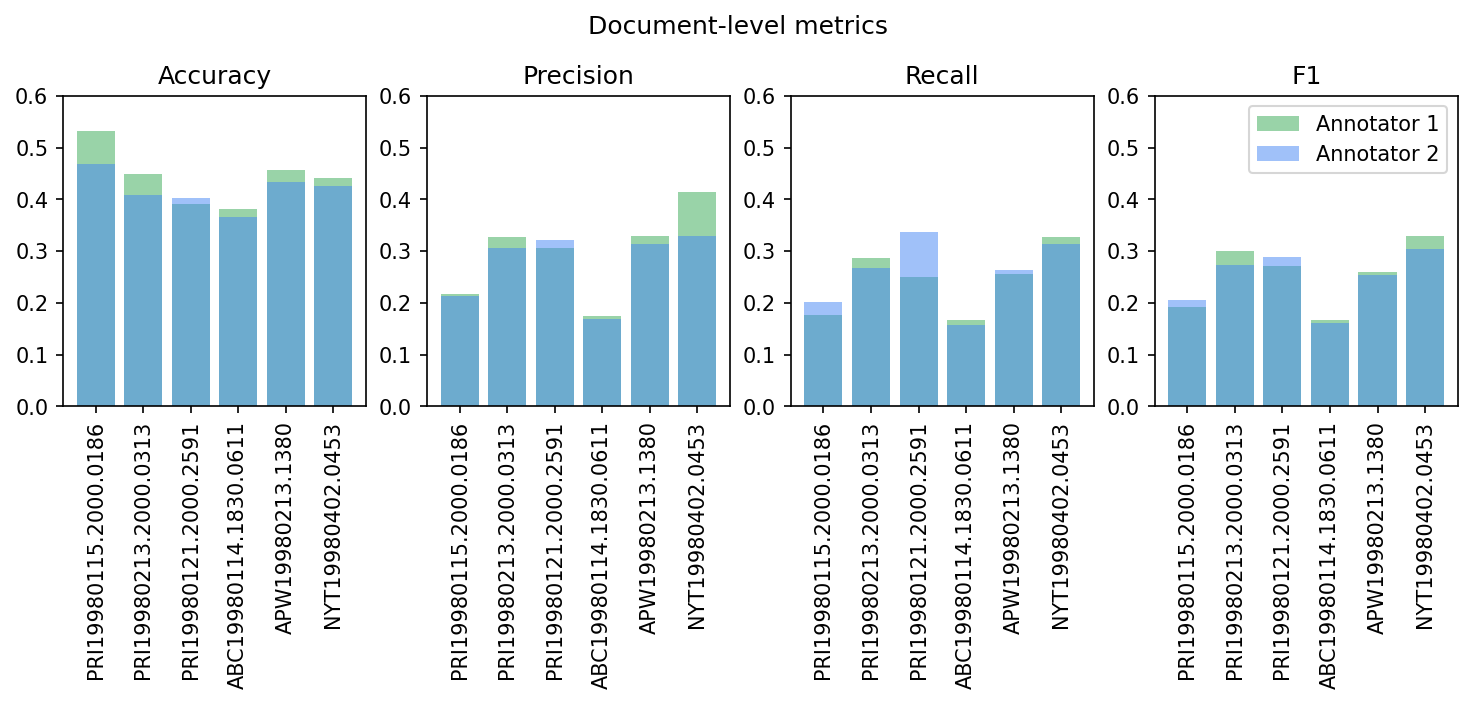

In [16]:
# make a bar plot with document-level metrics
doc2metrics_a1 = {}
doc2metrics_a2 = {}

for doc_id, predictions in doc2predictions.items():
    targets_a1 = doc2targets_a1[doc_id]
    targets_a2 = doc2targets_a2[doc_id]

    # -1 are on the main diagonal (SELF relation) and are ignored
    predictions = predictions[targets_a1 != -1]
    targets_a1 = targets_a1[targets_a1 != -1]
    targets_a2 = targets_a2[targets_a2 != -1]

    accuracy = (predictions == targets_a1).float().mean()
    p = precision_score(targets_a1, predictions, average="macro", zero_division=0)
    r = recall_score(targets_a1, predictions, average="macro", zero_division=0)
    f1 = f1_score(targets_a1, predictions, average="macro", zero_division=0)

    doc2metrics_a1[doc_id] = {
        "accuracy": accuracy.item(),
        "precision_macro": p,
        "recall_macro": r,
        "f1_macro": f1,
    }

    accuracy = (predictions == targets_a2).float().mean()
    p = precision_score(targets_a2, predictions, average="macro", zero_division=0)
    r = recall_score(targets_a2, predictions, average="macro", zero_division=0)
    f1 = f1_score(targets_a2, predictions, average="macro", zero_division=0)

    doc2metrics_a2[doc_id] = {
        "accuracy": accuracy.item(),
        "precision_macro": p,
        "recall_macro": r,
        "f1_macro": f1,
    }

# use matplotlib to make bar chart with document-level metrics
import matplotlib.pyplot as plt

metrics = ["accuracy", "precision_macro", "recall_macro", "f1_macro"]
metrics_to_name = {
    "accuracy": "Accuracy",
    "precision_macro": "Precision",
    "recall_macro": "Recall",
    "f1_macro": "F1",
}
num_metrics = len(metrics)

fig, axes = plt.subplots(1, num_metrics, figsize=(num_metrics * 3, 3))
fig.suptitle("Document-level metrics")
# move title up
fig.subplots_adjust(top=0.8)

# use nice colors for the bars
colors = ["#4285F4", "#EA4335", "#FBBC05", "#34A853"]
for i, metric in enumerate(metrics):
    values = [doc2metrics_a1[doc_id][metric] for doc_id in doc2metrics_a1]
    axes[i].bar(range(len(values)), values, color=colors[3], alpha=0.5, label="Annotator 1")
    values = [doc2metrics_a2[doc_id][metric] for doc_id in doc2metrics_a2]
    axes[i].bar(range(len(values)), values, color=colors[0], alpha=0.5, label="Annotator 2")

    axes[i].set_title(metrics_to_name[metric])
    # rotate xticks
    axes[i].tick_params(axis="x", rotation=90)
    # add doc ids as xticks
    axes[i].set_xticks(range(len(values)))
    axes[i].set_xticklabels(list(doc2metrics_a1.keys()))

    # ylim 0-0.6
    axes[i].set_ylim(0, 0.6)

    # on the last plot, make a legend
    if i == num_metrics - 1:
        axes[i].legend()

plt.show()

Text(0.5, 1.0, 'Distribution of Targets and Predictions')

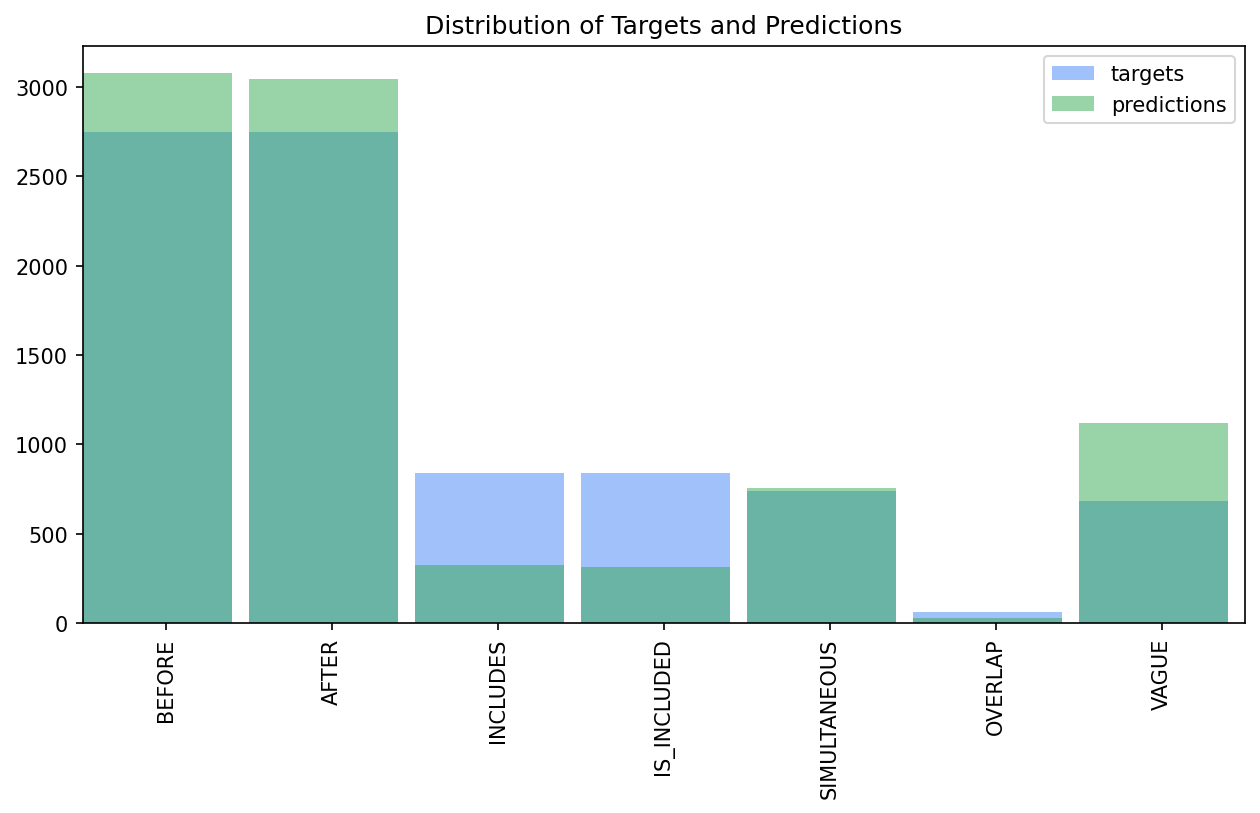

In [9]:
import numpy as np
import matplotlib.pyplot as plt

ID_TO_REL = [k for k, v in event_relations.REL_TO_ID.items()]

# Adjust the bins so that they are centered around the tick marks
bins = np.arange(NUM_RELATIONS + 1) - 0.5

# Set the width of each bar to be 0.9
bar_width = 0.9

# Set the plot size to be larger
plt.figure(figsize=(10, 5))

# Use the nice color scheme
bar_colors = ["#4285F4", "#EA4335", "#FBBC05", "#34A853"]

# Plot the histograms
plt.hist(all_targets[all_targets > -1].numpy(), bins=bins, alpha=0.5, label="targets", width=bar_width, color=bar_colors[0])
plt.hist(all_predictions[all_targets > -1].numpy(), bins=bins, alpha=0.5, label="predictions", width=bar_width, color=bar_colors[3])

# Set the x-axis limits to match the bins
plt.xlim((bins[0], bins[-1]))

# Label the x-axis with the relation names
plt.xticks(range(NUM_RELATIONS), ID_TO_REL, rotation=90)

# Add tick names
plt.gca().set_xticklabels(event_relations.REL_TO_ID, rotation=90, ha="center")

# Add a legend and a title
plt.legend()
plt.title("Distribution of Targets and Predictions")


Text(0.5, 127.03894767680974, 'Predicted label')

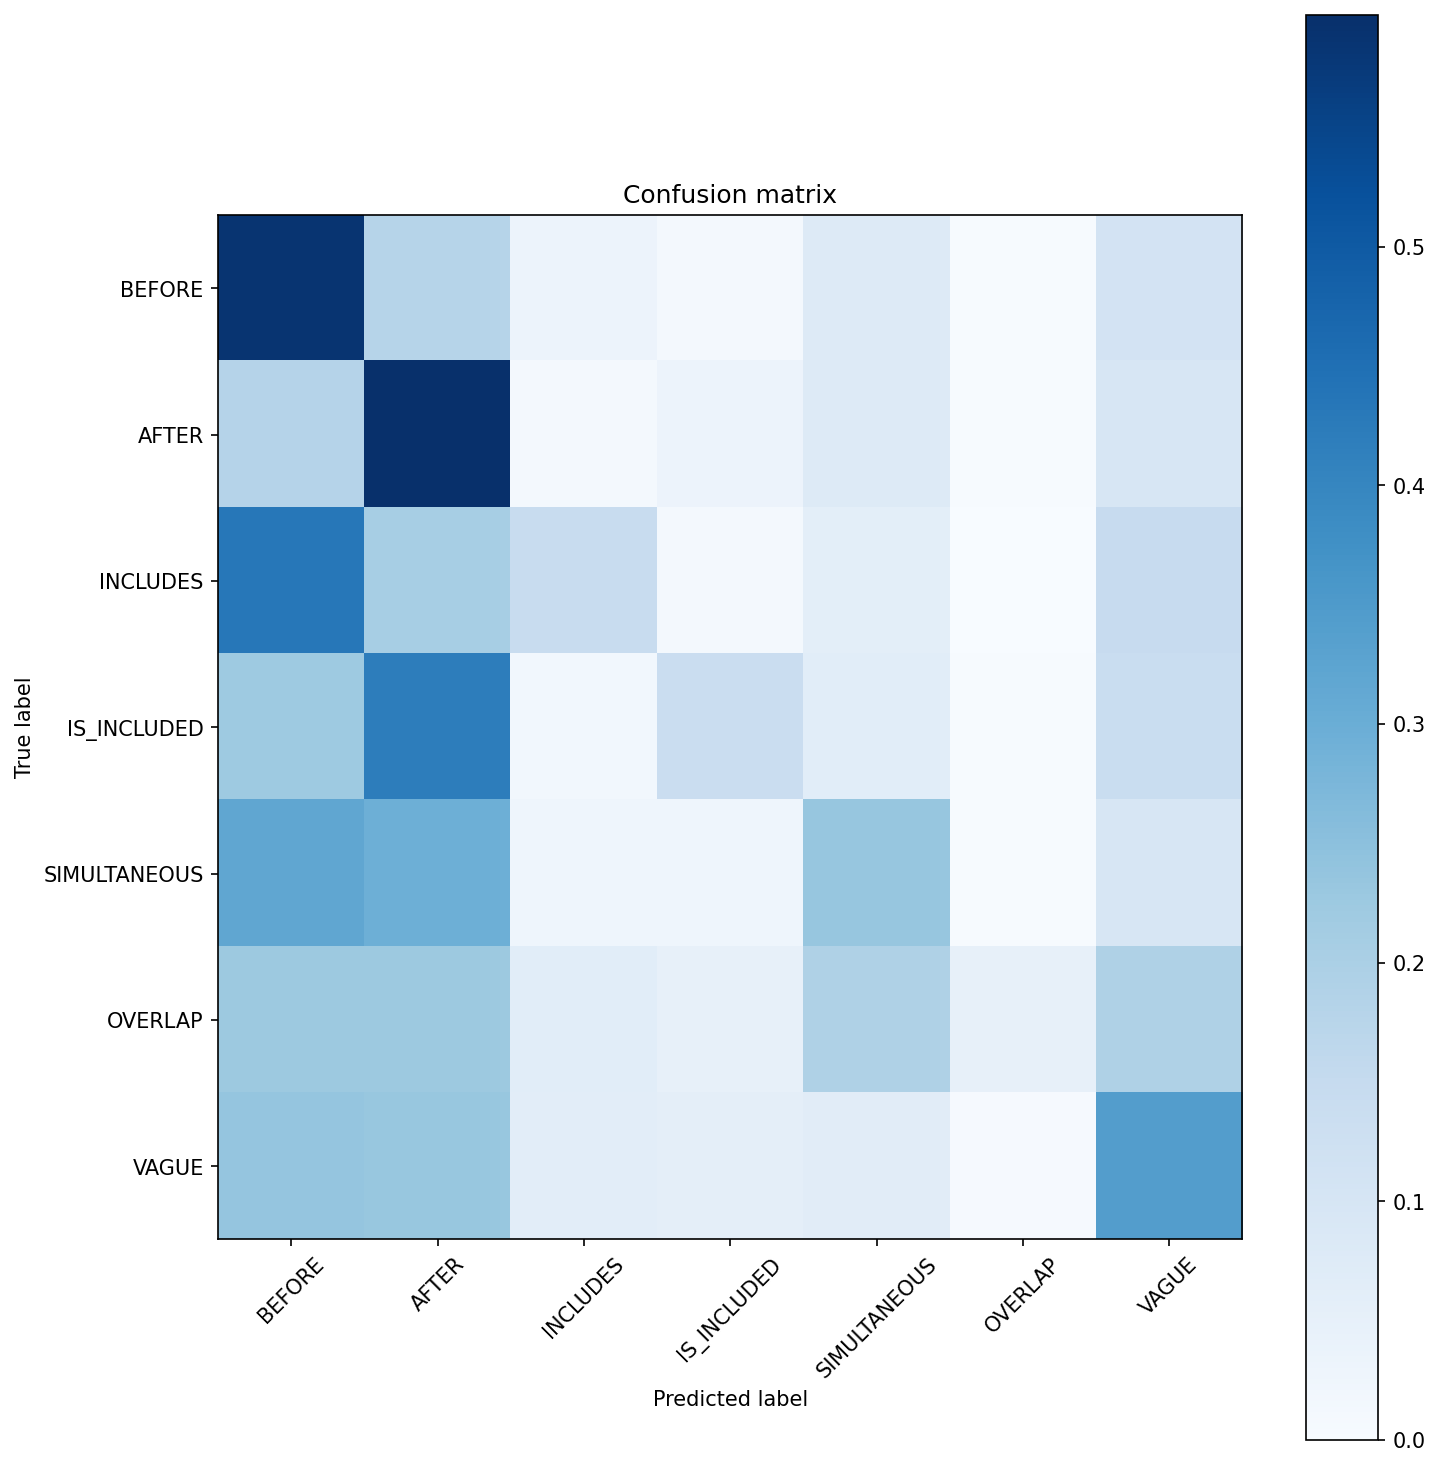

In [10]:
# plot confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


cm = confusion_matrix(all_targets[all_targets > -1].numpy(), all_predictions[all_targets > -1].numpy())
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(ID_TO_REL))
plt.xticks(tick_marks, ID_TO_REL, rotation=45)
plt.yticks(tick_marks, ID_TO_REL)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Text(0, 0.5, 'Accuracy')

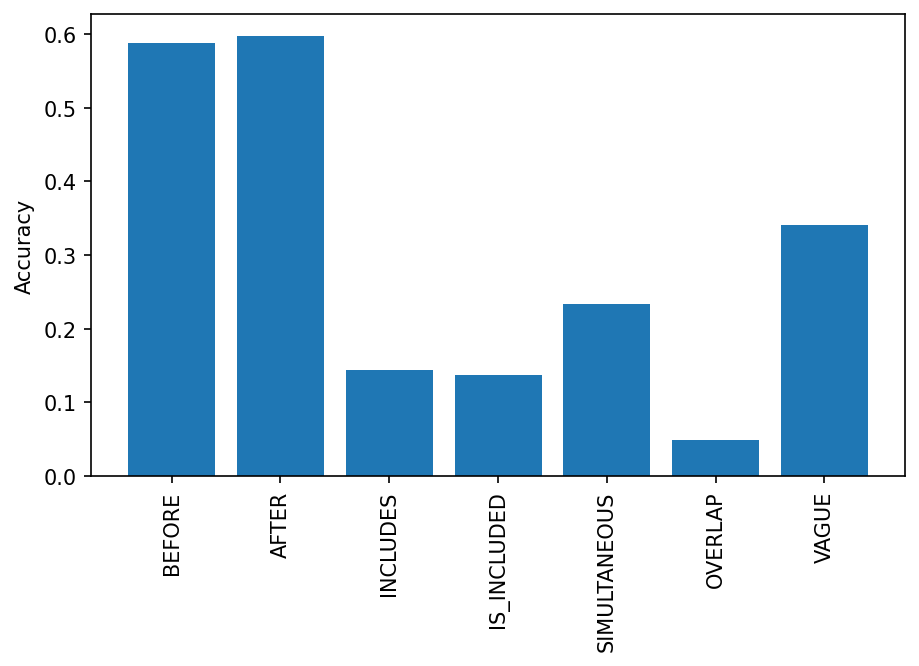

In [11]:
# compute accuracy per label
accuracy_per_label = []
for i in range(NUM_RELATIONS):
    accuracy_per_label.append((all_predictions[all_targets == i] == i).float().mean().item())

# plot accuracy per label
plt.figure(figsize=(7, 4))
plt.bar(range(NUM_RELATIONS), accuracy_per_label)
plt.xticks(range(NUM_RELATIONS), ID_TO_REL, rotation=90)
plt.ylabel("Accuracy")

In [13]:
def span_distance(span1, span2):
    """
    Returns the distance between two spans. The distance is defined as the number of tokens between the two spans.
    If the spans overlap, the distance is 0.
    """
    if span1[0] <= span2[0] <= span1[1] or span2[0] <= span1[0] <= span2[1]:
        return 0
    else:
        return min(abs(span1[0] - span2[1]), abs(span2[0] - span1[1]))

In [14]:
closeby_predictions = []
closeby_targets_a1 = []
closeby_targets_a2 = []

far_predictions = []
far_targets_a1 = []
far_targets_a2 = []

for annotation_id in TEST_DOCUMENTS:
    annotation = a1_annotations[annotation_id]
    annotation = modeling_utils.NTAnnotation.from_json(annotation)

    closeby_event_ids = []
    far_event_ids = []
    for left_event in annotation.events_and_timexes:
        left_span = left_event["span"]
        for right_event in annotation.events_and_timexes:
            right_span = right_event["span"]
            distance = span_distance(left_span, right_span)

            if distance < 10:
                left_event_id = annotation.event_id_to_numeric_id[left_event["id"]]
                right_event_id = annotation.event_id_to_numeric_id[right_event["id"]]
                closeby_event_ids.append((left_event_id, right_event_id))
                continue

            # check if spans are further than 100 words
            if distance > 100:
                left_event_id = annotation.event_id_to_numeric_id[left_event["id"]]
                right_event_id = annotation.event_id_to_numeric_id[right_event["id"]]
                far_event_ids.append((left_event_id, right_event_id))
                continue

    document_predictions = doc2predictions[annotation.doc_id].numpy()
    document_targets_a1 = doc2targets_a1[annotation.doc_id].numpy()
    document_targets_a2 = doc2targets_a2[annotation.doc_id].numpy()

    # get predictions for closeby event pairs
    for left_event_id, right_event_id in closeby_event_ids:
        closeby_predictions.append(document_predictions[left_event_id, right_event_id])
        closeby_targets_a1.append(document_targets_a1[left_event_id, right_event_id])
        closeby_targets_a2.append(document_targets_a2[left_event_id, right_event_id])

    # get predictions for far event pairs
    for left_event_id, right_event_id in far_event_ids:
        far_predictions.append(document_predictions[left_event_id, right_event_id])
        far_targets_a1.append(document_targets_a1[left_event_id, right_event_id])
        far_targets_a2.append(document_targets_a2[left_event_id, right_event_id])

# compute metrics for a1
a1_accuracy = accuracy_score(closeby_targets_a1, closeby_predictions)
a1_p = precision_score(closeby_targets_a1, closeby_predictions, average="macro")
a1_r = recall_score(closeby_targets_a1, closeby_predictions, average="macro")
a1_f1 = f1_score(closeby_targets_a1, closeby_predictions, average="macro")

# compute metrics for a2
a2_accuracy = accuracy_score(closeby_targets_a2, closeby_predictions)
a2_p = precision_score(closeby_targets_a2, closeby_predictions, average="macro")
a2_r = recall_score(closeby_targets_a2, closeby_predictions, average="macro")
a2_f1 = f1_score(closeby_targets_a2, closeby_predictions, average="macro")

# print statistics and metrics, average metrics across annotations
print("Number of closeby event pairs:", len(closeby_predictions))
print("Number of far event pairs:", len(far_predictions))

print("Closeby accuracy:", (a1_accuracy + a2_accuracy) / 2)
print("Closeby precision:", (a1_p + a2_p) / 2)
print("Closeby recall:", (a1_r + a2_r) / 2)
print("Closeby f1:", (a1_f1 + a2_f1) / 2)

# compute metrics for a1
a1_accuracy = accuracy_score(far_targets_a1, far_predictions)
a1_p = precision_score(far_targets_a1, far_predictions, average="macro")
a1_r = recall_score(far_targets_a1, far_predictions, average="macro")
a1_f1 = f1_score(far_targets_a1, far_predictions, average="macro")

# compute metrics for a2
a2_accuracy = accuracy_score(far_targets_a2, far_predictions)
a2_p = precision_score(far_targets_a2, far_predictions, average="macro")
a2_r = recall_score(far_targets_a2, far_predictions, average="macro")
a2_f1 = f1_score(far_targets_a2, far_predictions, average="macro")

print("Far accuracy:", (a1_accuracy + a2_accuracy) / 2)
print("Far precision:", (a1_p + a2_p) / 2)
print("Far recall:", (a1_r + a2_r) / 2)
print("Far f1:", (a1_f1 + a2_f1) / 2)

Number of closeby event pairs: 773
Number of far event pairs: 3236
Closeby accuracy: 0.2703751617076326
Closeby precision: 0.1699663432964766
Closeby recall: 0.23711757238071463
Closeby f1: 0.19367711407172766
Far accuracy: 0.4100741656365884
Far precision: 0.31921989475373636
Far recall: 0.27789031281311305
Far f1: 0.27923339738762704


/home/vlialin/miniconda3/envs/nt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vlialin/miniconda3/envs/nt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0, 0.5, 'Normalized Frequency')

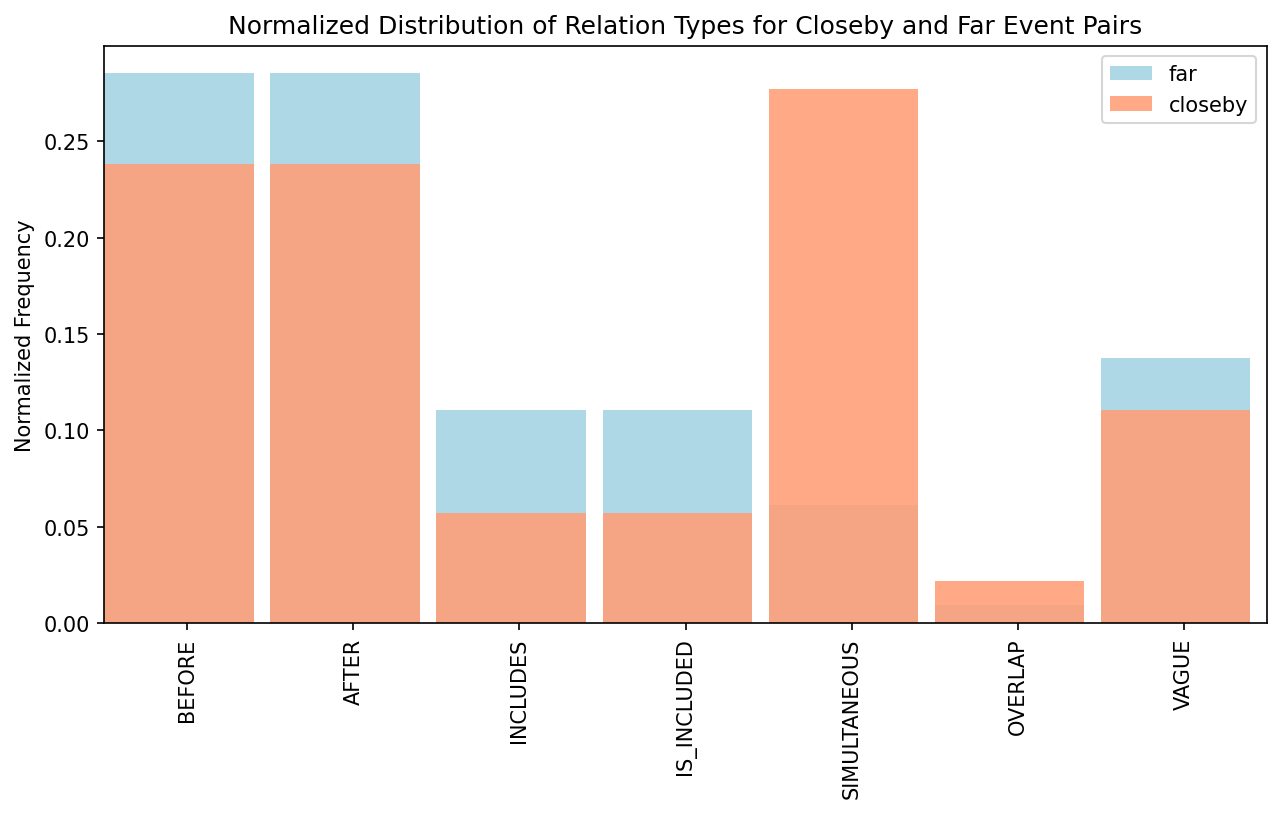

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Adjust the bins so that they are centered around the tick marks
bins = np.arange(NUM_RELATIONS + 1) - 0.5

# Set the width of each bar to be 0.9
bar_width = 0.9

# Set the plot size to be larger
plt.figure(figsize=(10, 5))

# Set the colors for the bars
bar_colors = ["#FFA07A", "#ADD8E6"]

# Plot the histograms for closeby and far event pairs
plt.hist(far_targets_a1 + far_targets_a2, bins=bins, alpha=0.99, label="far", width=bar_width, color=bar_colors[1], density=True)
plt.hist(closeby_targets_a1 + closeby_targets_a2, bins=bins, alpha=0.9, label="closeby", width=bar_width, color=bar_colors[0], density=True)

# Set the x-axis limits to match the bins
plt.xlim((bins[0], bins[-1]))

# Label the x-axis with the relation names
plt.xticks(range(NUM_RELATIONS), ID_TO_REL, rotation=90)

# Add tick names
plt.gca().set_xticklabels(ID_TO_REL, rotation=90, ha="center")

# Add a legend and a title
plt.legend(loc="upper right")
plt.title("Normalized Distribution of Relation Types for Closeby and Far Event Pairs")

# Add a y-axis label
plt.ylabel("Normalized Frequency")
